# Регуляризация в линейных моделях

В этом ноутбуке мы подробно разберём **регуляризацию** в контексте классических моделей машинного обучения, прежде всего линейной и логистической регрессии.

Мы обсудим:

- зачем вообще нужна регуляризация;
- как возникает переобучение и связь с **bias–variance trade-off**;
- формальную постановку задачи как оптимизации **эмпирического риска с регуляризацией**;
- два основных вида регуляризации: **$L2$ (Ridge)** и **$L1$ (Lasso)**;
- кратко упомянем **Elastic Net** как комбинацию $L1$ и $L2$;
- покажем на примерах, как регуляризация влияет на кривые, веса и качество на трейне/тесте;
- посмотрим, как регуляризация устроена в **логистической регрессии** и как интерпретировать параметр $C$ в `sklearn`.


## 1. Зачем нужна регуляризация

Интуитивно, регуляризация нужна для того, чтобы модель:

- хорошо работала **не только на обучающей выборке**, но и на новых данных;
- не подстраивалась под **случайный шум**;
- оставалась **достаточно простой**, даже если мы даём ей возможность быть очень гибкой.

Типичная ситуация:

1. Мы берём довольно мощную модель (например, полиномиальную регрессию высокой степени).
2. Она идеально подгоняется под обучающие точки (ошибка почти $0$).
3. На тестовой выборке оказывается, что качество плохое.

Это и есть **переобучение** (overfitting). Регуляризация вводит **штраф за сложность модели**, чтобы снизить риск переобучения.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

np.random.seed(42)

### 1.1. Игрушечный пример переобучения

Сгенерируем одномерные данные для регрессии. Пусть истинная зависимость:

$$
y = \sin(2 \pi x) + \varepsilon,
$$

где $x \in [0, 1]$, а $\varepsilon$ — гауссовский шум.

Мы попробуем аппроксимировать эти данные полиномиальной регрессией высокой степени **без регуляризации** и посмотрим, что получится.


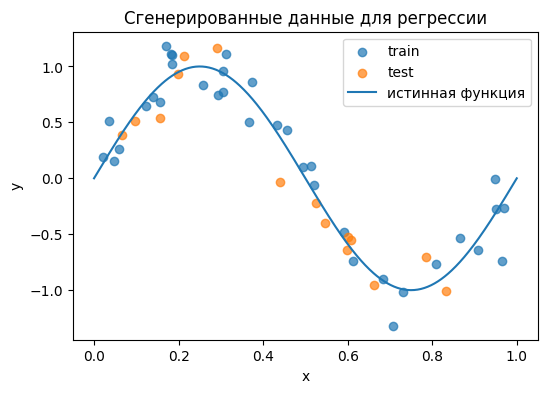

In [2]:
# Генерация данных для регрессии
n_samples = 50
X = np.random.rand(n_samples, 1)
noise = 0.2 * np.random.randn(n_samples,)
y = np.sin(2 * np.pi * X[:, 0]) + noise

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Визуализация данных
xs = np.linspace(0, 1, 500).reshape(-1, 1)
ys_true = np.sin(2 * np.pi * xs[:, 0])

plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], y_train, label="train", alpha=0.7)
plt.scatter(X_test[:, 0], y_test, label="test", alpha=0.7)
plt.plot(xs[:, 0], ys_true, label="истинная функция")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Сгенерированные данные для регрессии")
plt.show()

Попробуем обучить **полиномиальную регрессию степени $15$** без регуляризации и посмотрим, как она ведёт себя на трейне и на тесте.


MSE train: 0.009903064912010111
MSE test: 0.05695815171343457


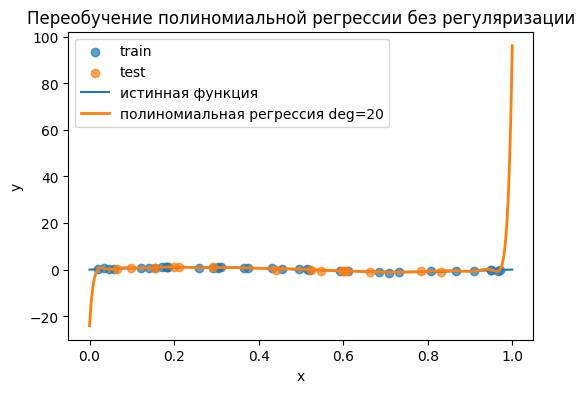

In [11]:
degree = 20

model_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
    ("linreg", LinearRegression())
])

model_poly.fit(X_train, y_train)

y_train_pred = model_poly.predict(X_train)
y_test_pred = model_poly.predict(X_test)

print("MSE train:", mean_squared_error(y_train, y_train_pred))
print("MSE test:", mean_squared_error(y_test, y_test_pred))

# Визуализация предсказаний
ys_pred = model_poly.predict(xs)

plt.figure(figsize=(6, 4))
plt.scatter(X_train[:, 0], y_train, label="train", alpha=0.7)
plt.scatter(X_test[:, 0], y_test, label="test", alpha=0.7)
plt.plot(xs[:, 0], ys_true, label="истинная функция")
plt.plot(xs[:, 0], ys_pred, label=f"полиномиальная регрессия deg={degree}", linewidth=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Переобучение полиномиальной регрессии без регуляризации")
plt.show()

На графике видно, что полиномиальная регрессия степени $20$:

- практически идеально подгоняет обучающие точки;
- строит очень **рифлёную, нестабильную** кривую;
- на тестовой выборке ошибка заметно выше, чем на трейне.

Это пример переобучения. Регуляризация — способ контролировать сложность модели и бороться с переобучением.


## 2. Эмпирический риск и регуляризация

Многие модели машинного обучения можно записать в виде минимизации **эмпирического риска**:

$$
\min_w \; \frac{1}{n} \sum_{i=1}^n L(y_i, f(x_i; w)),
$$

где:

- $x_i$ — объекты,
- $y_i$ — ответы,
- $f(x; w)$ — модель с параметрами $w$,
- $L(y, \hat{y})$ — функция потерь (например, квадратичная ошибка, логистическая потеря и т.п.).

**Регуляризация** добавляет к этому функционалу **штраф за сложность модели**:

$$
\min_w \; \frac{1}{n} \sum_{i=1}^n L(y_i, f(x_i; w)) + \lambda \Omega(w),
$$

где:

- $\Omega(w)$ — функция, измеряющая сложность модели (например, норму весов),
- $\lambda \ge 0$ — коэффициент регуляризации, управляющий силой штрафа.

Интерпретация:

- при **большом $\lambda$** модель сильнее штрафуется за большие веса, становится проще и устойчивее;
- при **маленьком $\lambda$** штраф слабее, модель может становиться более сложной и склонной к переобучению.


## 3. $L2$ регуляризация (Ridge)

В линейной регрессии модель имеет вид:

$$
f(x; w) = w^\top x + b.
$$

Классическая МНК-задача без регуляризации:

$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n \bigl(y_i - (w^\top x_i + b)\bigr)^2.
$$

В **Ridge-регрессии** (также называемой **$L2$-регрессией**) мы добавляем штраф на норму весов:

$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n \bigl(y_i - (w^\top x_i + b)\bigr)^2 + \lambda \lVert w \rVert_2^2,
$$

где $\lVert w \rVert_2^2 = \sum_{j} w_j^2$.

Интуитивно:

- модель всё ещё старается минимизировать квадратичную ошибку на данных;
- но за большие по модулю веса накладывается штраф;
- это приводит к тому, что веса становятся "меньше" и решение сглаживается.

В `sklearn` параметр регуляризации Ridge обычно называется `alpha` и соответствует $\lambda$ из формулы выше.


### 3.1. Ridge-регрессия на нашем примере

Посмотрим, как Ridge-регрессия влияет на поведение полиномиальной модели высокой степени.

Сделаем пайплайн:

- масштабирование признаков (важно для корректной регуляризации),
- генерация полиномиальных признаков степени $20$,
- Ridge-регрессия с разными значениями `alpha`.


=== LinearRegression (alpha=0) ===
MSE train: 0.009903064912010111
MSE test: 0.05695815171343457


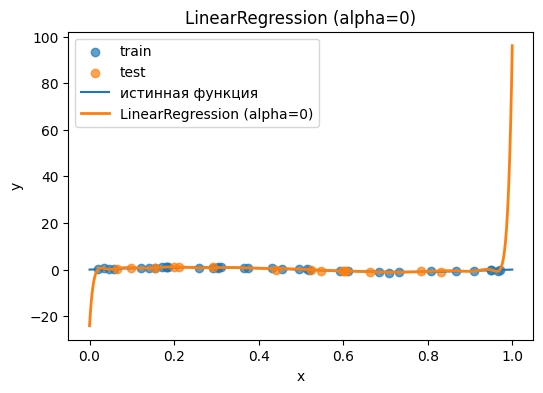

=== Ridge alpha=0.001 ===
MSE train: 0.02885661178638468
MSE test: 0.03927804483195599


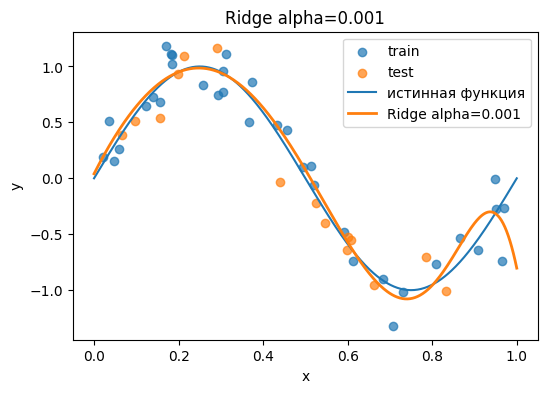

=== Ridge alpha=0.01 ===
MSE train: 0.03013337505235203
MSE test: 0.04398854982695077


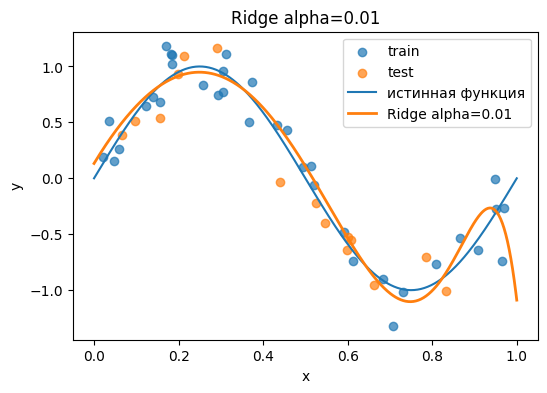

=== Ridge alpha=0.1 ===
MSE train: 0.045153327075774
MSE test: 0.06685242387558292


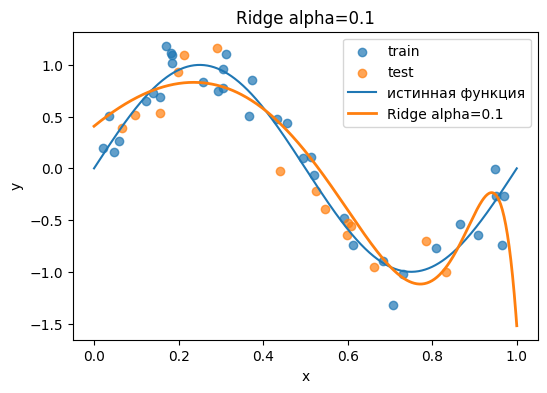

=== Ridge alpha=1.0 ===
MSE train: 0.1040556750245509
MSE test: 0.1075890298723975


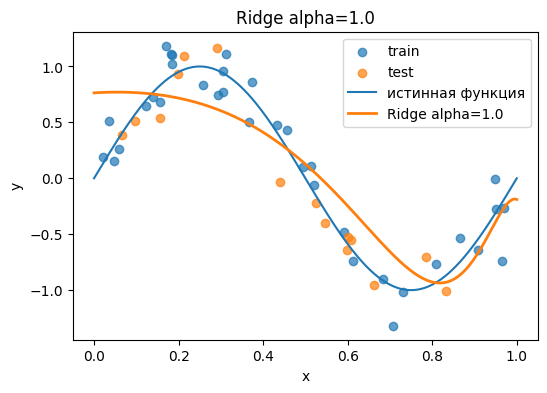

=== Ridge alpha=10.0 ===
MSE train: 0.16175253709489315
MSE test: 0.17622910668815447


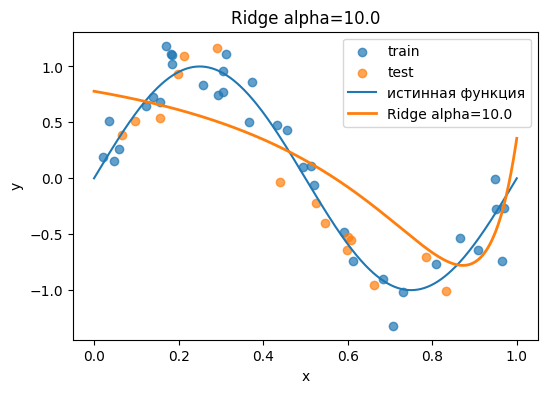

In [12]:
alphas = [0.0, 1e-3, 1e-2, 1e-1, 1.0, 10.0]

for alpha in alphas:
    if alpha == 0.0:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        label = "LinearRegression (alpha=0)"
    else:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])
        label = f"Ridge alpha={alpha}"

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("===", label, "===")
    print("MSE train:", mean_squared_error(y_train, y_train_pred))
    print("MSE test:", mean_squared_error(y_test, y_test_pred))

    ys_pred = model.predict(xs)

    plt.figure(figsize=(6, 4))
    plt.scatter(X_train[:, 0], y_train, label="train", alpha=0.7)
    plt.scatter(X_test[:, 0], y_test, label="test", alpha=0.7)
    plt.plot(xs[:, 0], ys_true, label="истинная функция")
    plt.plot(xs[:, 0], ys_pred, label=label, linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(label)
    plt.show()

Наблюдения:

- при $\alpha = 0$ это обычная полиномиальная регрессия, сильно переобученная;
- при маленьком $\alpha$ кривая всё ещё гибкая, но уже менее рваная;
- при умеренных значениях $\alpha$ модель становится заметно **более гладкой**, а ошибка на тесте снижается;
- при слишком большом $\alpha$ модель может стать слишком простой и начать недообучаться.

Ridge-регрессия **не зануляет** коэффициенты, но делает их "маленькими" и стабилизирует решение.


## 4. $L1$ регуляризация (Lasso)

В **Lasso-регрессии** (от англ. Least Absolute Shrinkage and Selection Operator) используется штраф на сумму модулей весов:

$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n \bigl(y_i - (w^\top x_i + b)\bigr)^2 + \lambda \lVert w \rVert_1,
$$

где $\lVert w \rVert_1 = \sum_j |w_j|$.

В отличие от $L2$:

- $L1$-штраф не только стремится сделать веса маленькими,
- но и имеет тенденцию занулять некоторые из них **совсем**.

Поэтому Lasso часто используют как способ **встроенного отбора признаков**: признаки, у которых вес стал равен $0$, можно считать неиспользуемыми моделью.

В `sklearn` параметр `alpha` в `Lasso` аналогично соответствует коэффициенту $\lambda$ перед $L1$-штрафом.


### 4.1. Lasso-регрессия и зануление коэффициентов

Посмотрим на те же полиномиальные признаки и посмотрим, сколько коэффициентов зануляется при разных `alpha`.


=== Lasso alpha= 0.0001 ===
Всего признаков: 20
Нулевых коэффициентов: 7
MSE train: 0.029016419272368036
MSE test: 0.03889163540683695


C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-02, tolerance: 1.717e-03
  model = cd_fast.enet_coordinate_descent(


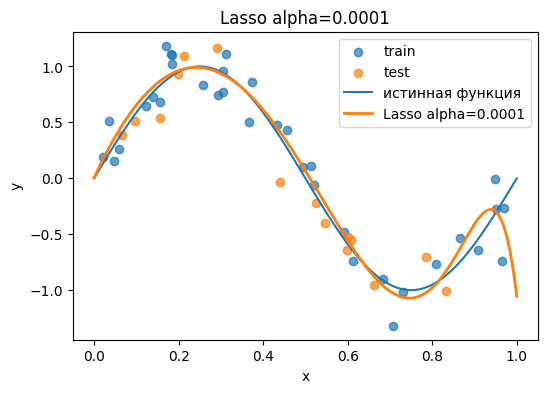

=== Lasso alpha= 0.001 ===
Всего признаков: 20
Нулевых коэффициентов: 14
MSE train: 0.03088647146983808
MSE test: 0.04498684164127833


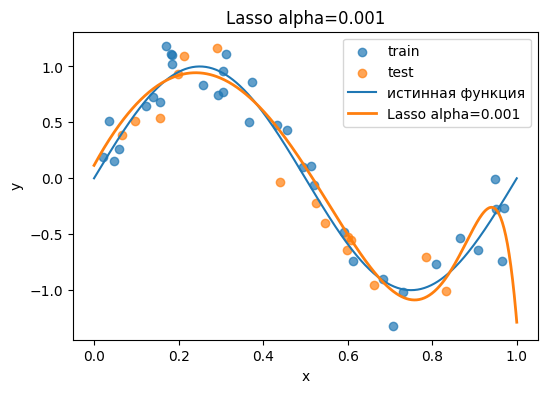

=== Lasso alpha= 0.003 ===
Всего признаков: 20
Нулевых коэффициентов: 16
MSE train: 0.03923137957981163
MSE test: 0.05494171028222548


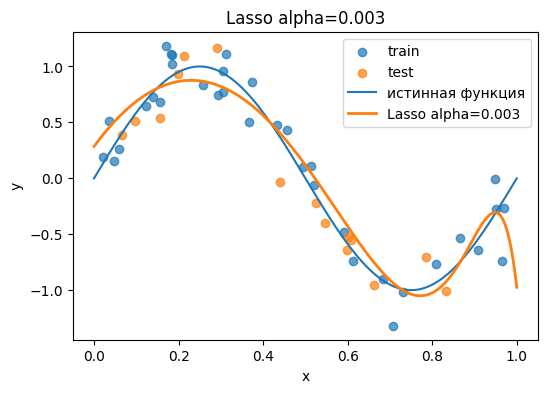

=== Lasso alpha= 0.005 ===
Всего признаков: 20
Нулевых коэффициентов: 15
MSE train: 0.05375361831882052
MSE test: 0.06732859608773403


C:\work\PISH\data_analysis_lectures\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.411e-03, tolerance: 1.717e-03
  model = cd_fast.enet_coordinate_descent(


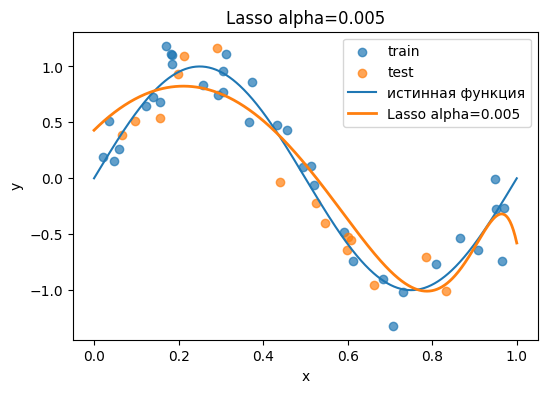

=== Lasso alpha= 0.01 ===
Всего признаков: 20
Нулевых коэффициентов: 16
MSE train: 0.10332101248099848
MSE test: 0.09957916843240965


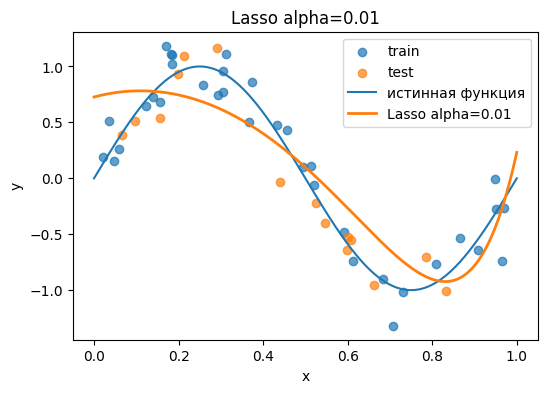

=== Lasso alpha= 0.1 ===
Всего признаков: 20
Нулевых коэффициентов: 18
MSE train: 0.2244078832819989
MSE test: 0.2620858221839208


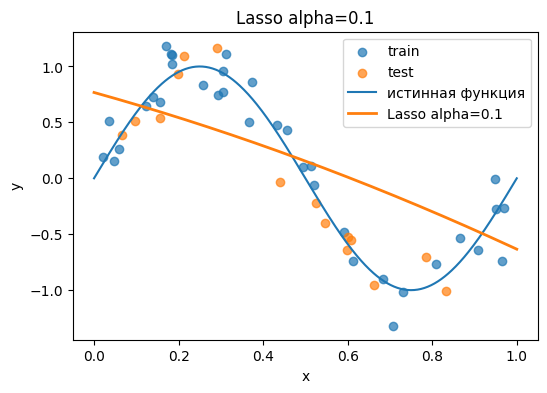

=== Lasso alpha= 1.0 ===
Всего признаков: 20
Нулевых коэффициентов: 20
MSE train: 0.4906902317229037
MSE test: 0.5636747990914526


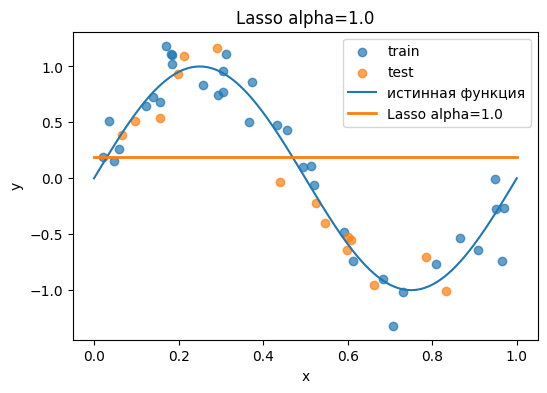

In [15]:
alphas_lasso = [1e-4, 1e-3, 3e-3, 5e-3, 1e-2, 1e-1, 1.0]

for alpha in alphas_lasso:
    model_lasso = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("lasso", Lasso(alpha=alpha, max_iter=10000))
    ])

    model_lasso.fit(X_train, y_train)

    # Извлекаем веса после Lasso
    poly = model_lasso.named_steps["poly"]
    lasso = model_lasso.named_steps["lasso"]

    feature_names = poly.get_feature_names_out(["x"])
    coefs = lasso.coef_

    n_zero = np.sum(coefs == 0.0)
    n_total = coefs.shape[0]

    y_train_pred = model_lasso.predict(X_train)
    y_test_pred = model_lasso.predict(X_test)

    print("=== Lasso alpha=", alpha, "===")
    print("Всего признаков:", n_total)
    print("Нулевых коэффициентов:", n_zero)
    print("MSE train:", mean_squared_error(y_train, y_train_pred))
    print("MSE test:", mean_squared_error(y_test, y_test_pred))

    ys_pred = model_lasso.predict(xs)

    plt.figure(figsize=(6, 4))
    plt.scatter(X_train[:, 0], y_train, label="train", alpha=0.7)
    plt.scatter(X_test[:, 0], y_test, label="test", alpha=0.7)
    plt.plot(xs[:, 0], ys_true, label="истинная функция")
    plt.plot(xs[:, 0], ys_pred, label=f"Lasso alpha={alpha}", linewidth=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title(f"Lasso alpha={alpha}")
    plt.show()

Можно заметить, что по мере увеличения $\alpha$:

- растёт доля нулевых коэффициентов (меньше используемых признаков);
- модель становится проще и менее подверженной переобучению;
- при слишком большом $\alpha$ модель начинает недообучаться и теряет способность аппроксимировать истинную зависимость.

Таким образом, Lasso можно рассматривать как способ одновременно **регуляризовывать** модель и **отбирать признаки**.


## 5. Elastic Net

**Elastic Net** сочетает в себе преимущества $L1$ и $L2$ регуляризации.

Идея: использовать комбинацию $L1$ и $L2$ штрафов:

$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n L\bigl(y_i, f(x_i; w)\bigr) + \alpha \bigl(\rho \lVert w \rVert_1 + (1 - \rho) \lVert w \rVert_2^2\bigr),
$$

где:

- $\alpha \ge 0$ — общий коэффициент регуляризации,
- $\rho \in [0, 1]$ — параметр, задающий баланс между $L1$ и $L2$.

Преимущества Elastic Net:

- унаследует **способность Lasso занулять признаки**;
- при этом **устойчивее**, когда признаки сильно коррелированы (где чистый Lasso может вести себя нестабильно).

В `sklearn` это реализовано в `ElasticNet` (для регрессии) и через параметры `penalty` и `l1_ratio` в некоторых классификаторах.


In [ ]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(alpha=0.1, l1_ratio=0.8, max_iter=10000)

## 6. Регуляризация в логистической регрессии

Логистическая регрессия для бинарной классификации минимизирует логистическую функцию потерь:

$$
L(\hat{y}, y) = \log\bigl(1 + \exp(-y \hat{y})\bigr),
$$

где $y \in \{-1, 1\}$, а $\hat{y} = w^\top x + b$.

Без регуляризации задача выглядит так:

$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n \log\bigl(1 + \exp(-y_i (w^\top x_i + b))\bigr).
$$

С регуляризацией:

$$
\min_{w, b} \; \frac{1}{n} \sum_{i=1}^n \log\bigl(1 + \exp(-y_i (w^\top x_i + b))\bigr) + \lambda \cdot \Omega(w),
$$

где $\Omega(w)$ может быть $L2$ или $L1$ нормой.

В `sklearn` для `LogisticRegression`:

- используется параметр `C`, который равен примерно $\frac{1}{\lambda}$;
- **большое $C$** означает **слабую регуляризацию**;
- **малое $C$** означает **сильную регуляризацию**.

Это важно: в линейной и Ridge-регрессии мы обычно думаем в терминах $\lambda$, а в логистической регрессии `sklearn` предлагает параметр `C = 1 / \lambda`.


### 6.1. Пример: влияние регуляризации в логистической регрессии

Сгенерируем датасет для классификации с большим числом признаков, среди которых лишь часть информативны. Посмотрим, как меняются веса и качество при разных значениях $C$.


In [16]:
from sklearn.datasets import make_classification

X_clf, y_clf = make_classification(
    n_samples=500,
    n_features=20,
    n_informative=5,
    n_redundant=5,
    n_repeated=0,
    n_classes=2,
    random_state=42
)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.3, random_state=42, stratify=y_clf
)

Cs = [0.01, 0.1, 1.0, 10.0, 100.0]

for C in Cs:
    logreg = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            C=C,
            penalty="l2",
            solver="lbfgs",
            max_iter=10000
        ))
    ])

    logreg.fit(Xc_train, yc_train)
    yc_train_pred = logreg.predict(Xc_train)
    yc_test_pred = logreg.predict(Xc_test)

    clf_step = logreg.named_steps["clf"]
    coefs = clf_step.coef_[0]

    print("=== C =", C, "===")
    print("Accuracy train:", accuracy_score(yc_train, yc_train_pred))
    print("Accuracy test:", accuracy_score(yc_test, yc_test_pred))
    print("Норма вектора весов:", np.linalg.norm(coefs))
    print()

=== C = 0.01 ===
Accuracy train: 0.82
Accuracy test: 0.8466666666666667
Норма вектора весов: 0.6610866142939482

=== C = 0.1 ===
Accuracy train: 0.8285714285714286
Accuracy test: 0.8533333333333334
Норма вектора весов: 1.5388906141910723

=== C = 1.0 ===
Accuracy train: 0.8342857142857143
Accuracy test: 0.8533333333333334
Норма вектора весов: 2.053822875088141

=== C = 10.0 ===
Accuracy train: 0.8371428571428572
Accuracy test: 0.8466666666666667
Норма вектора весов: 2.150935362979959

=== C = 100.0 ===
Accuracy train: 0.8371428571428572
Accuracy test: 0.8466666666666667
Норма вектора весов: 2.1616879229963675



Можно заметить, что:

- при **маленьком $C$** (сильная регуляризация) веса меньше по норме, модель более "консервативна";
- при **большом $C$** (слабая регуляризация) веса по норме растут, модель может сильнее подстраиваться под обучающую выборку;
- качество на тесте может быть лучше при некотором промежуточном значении $C$, а не при максимально большом.

На практике $C$ подбирают по валидации или кросс-валидации.


## 7. Регуляризация и bias–variance trade-off

Интуитивно, регуляризация влияет на баланс между:

- **смещением** (bias) — насколько модель грубо аппроксимирует истинную зависимость;
- **дисперсией** (variance) — насколько модель чувствительна к конкретной выборке и шуму.

Простая модель (сильная регуляризация):

- имеет высокое смещение (может недообучаться);
- низкую дисперсию (устойчива к шуму и конкретной выборке).

Сложная модель (слабая регуляризация):

- имеет низкое смещение (может хорошо описывать сложные зависимости);
- высокую дисперсию (может сильно меняться от выборки к выборке и переобучаться).

Регуляризация позволяет управлять этим балансом, подбирая $\lambda$ (или $C$) так, чтобы **ошибка на новых данных** была минимальной.


### 7.1. Пример: зависимость ошибки от силы регуляризации

Посмотрим, как ошибка на трейне и на тесте меняется в зависимости от `alpha` в Ridge-регрессии на нашем полиномиальном примере.


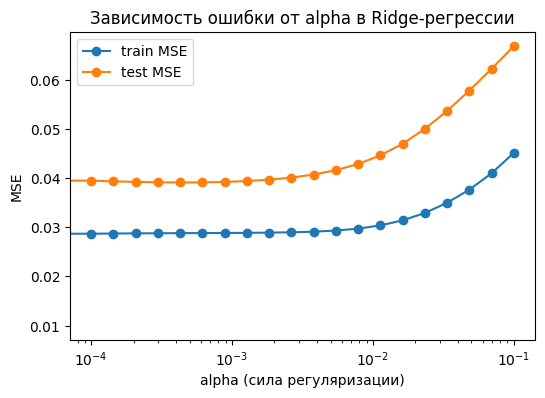

In [26]:
alphas_grid = [0] + np.logspace(-4, -1, 20).tolist()
train_errors = []
test_errors = []

for alpha in alphas_grid:
    if alpha == 0.0:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("linreg", LinearRegression())
        ])
    else:
        model = Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(6, 4))
plt.plot(alphas_grid, train_errors, marker="o", label="train MSE")
plt.plot(alphas_grid, test_errors, marker="o", label="test MSE")
plt.xscale("log")
plt.xlabel("alpha (сила регуляризации)")
plt.ylabel("MSE")
plt.title("Зависимость ошибки от alpha в Ridge-регрессии")
plt.legend()
plt.show()

Что часто можно увидеть в реальных задачах:

- при слишком маленьком $\alpha$ (почти нет регуляризации) модель переобучается: ошибка на трейне очень мала, на тесте выше;
- при слишком большом $\alpha$ модель недообучается: обе ошибки высокие, особенно на тесте;
- при некотором промежуточном $\alpha$ ошибка на тесте минимальна — это и есть разумный компромисс между сложностью модели и её устойчивостью.


## 8. Практические рекомендации по регуляризации

1. **Всегда масштабируйте признаки** перед $L2$ и $L1$ регуляризацией (StandardScaler или аналоги). Иначе штраф будет зависеть от масштабов признаков, а не только от логики задачи.

2. **Ridge-регрессия**:
   - хорошо подходит, когда много признаков и они могут быть коррелированы;
   - сглаживает веса, но не зануляет их;
   - часто используется как базовая регуляризованная модель.

3. **Lasso-регрессия**:
   - полезна, когда ожидается, что многие признаки не нужны, и хочется получить **разреженное** решение;
   - может нестабильно вести себя при сильной корреляции признаков;
   - удобна как способ встроенного отбора признаков.

4. **Elastic Net**:
   - сочетает плюсы $L1$ и $L2$;
   - лучше ведёт себя при коррелированных признаках, чем чистое Lasso;
   - удобен как универсальный выбор, если нет сильных предпочтений.

5. **Выбор силы регуляризации** ($\lambda$ или $C$):
   - делайте это по валидации или кросс-валидации;
   - не доверяйте только ошибке на трейне;
   - на практике используют логарифмическую сетку значений (например, $10^{-4}, 10^{-3}, \dots, 10^2$).

6. **Интерпретация параметров в `sklearn`**:
   - в `Ridge` и `Lasso` параметр `alpha` соответствует $\lambda$;
   - в `LogisticRegression` и некоторых других моделях параметр $C$ соответствует примерно $1 / \lambda$;
   - не забывайте об этой разнице при переносе интуиции между моделями.

7. **Связь с другими моделями**:
   - многие методы, такие как SVM, также можно интерпретировать как минимизацию регуляризованного риска с $L2$-штрафом;
   - понимание регуляризации в линейных моделях помогает легче понять и эти методы.
